In [3]:
!wget https://data.deepai.org/conll2003.zip


--2022-03-20 20:48:19--  https://data.deepai.org/conll2003.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 982975 (960K) [application/x-zip-compressed]
Saving to: ‘conll2003.zip’

conll2003.zip       100%[===================>] 959.94K   615KB/s    in 1.6s    

2022-03-20 20:48:22 (615 KB/s) - ‘conll2003.zip’ saved [982975/982975]



In [5]:
!unzip conll2003.zip

Archive:  conll2003.zip
  inflating: metadata                
  inflating: test.txt                
  inflating: train.txt               
  inflating: valid.txt               


In [50]:
with open("train.txt") as f:
  string = ''.join(f.readlines())
dataset = string.split('\n')


In [55]:
from itertools import groupby

for x in groupby(dataset, lambda x:x==''):
  print(x)
  break

(False, <itertools._grouper object at 0x7f3292c64dc0>)


In [57]:
dataset_in_sentence = [list(group) for k, group in groupby(dataset, lambda x: x == "") if not k]

In [58]:
dataset_in_sentence

[['-DOCSTART- -X- -X- O'],
 ['EU NNP B-NP B-ORG',
  'rejects VBZ B-VP O',
  'German JJ B-NP B-MISC',
  'call NN I-NP O',
  'to TO B-VP O',
  'boycott VB I-VP O',
  'British JJ B-NP B-MISC',
  'lamb NN I-NP O',
  '. . O O'],
 ['Peter NNP B-NP B-PER', 'Blackburn NNP I-NP I-PER'],
 ['BRUSSELS NNP B-NP B-LOC', '1996-08-22 CD I-NP O'],
 ['The DT B-NP O',
  'European NNP I-NP B-ORG',
  'Commission NNP I-NP I-ORG',
  'said VBD B-VP O',
  'on IN B-PP O',
  'Thursday NNP B-NP O',
  'it PRP B-NP O',
  'disagreed VBD B-VP O',
  'with IN B-PP O',
  'German JJ B-NP B-MISC',
  'advice NN I-NP O',
  'to TO B-PP O',
  'consumers NNS B-NP O',
  'to TO B-VP O',
  'shun VB I-VP O',
  'British JJ B-NP B-MISC',
  'lamb NN I-NP O',
  'until IN B-SBAR O',
  'scientists NNS B-NP O',
  'determine VBP B-VP O',
  'whether IN B-SBAR O',
  'mad JJ B-NP O',
  'cow NN I-NP O',
  'disease NN I-NP O',
  'can MD B-VP O',
  'be VB I-VP O',
  'transmitted VBN I-VP O',
  'to TO B-PP O',
  'sheep NN B-NP O',
  '. . O O'],


In [173]:
import random 
import numpy as np
import torch
class NERDataset:
  def __init__(self, txt_path):
    with open("train.txt") as f:
      string = ''.join(f.readlines())
    dataset = string.lower().split('\n')
    dataset_in_sentence = [list(group) for k, group in groupby(dataset, lambda x: x == "") if not k]
    self.ner_label_type = list(set([x.split(' ')[-1] for x in dataset]))
    self.type2idx = {x:i for i, x in enumerate(self.ner_label_type)}
    self.data = dataset_in_sentence
    
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    sentence = self.data[idx]
    rand_idx = random.randint(0, len(sentence)-1)
    center_word = sentence[rand_idx].split(' ')[0]
    
    left_word = [x.split(' ')[0] for x in sentence[max(rand_idx-2,0):rand_idx]]
    right_word = [x.split(' ')[0] for x in sentence[rand_idx+1:rand_idx+3]]
    
    if rand_idx <2:
      left_word =  ["PAD" for i in range(2-rand_idx)] + left_word
    right_margin = len(sentence)-1 - rand_idx
    if right_margin <2:
      right_word = right_word +  ["PAD" for i in range(2-right_margin)]
    
    word_sequence = left_word + [center_word] + right_word
    
    
    return torch.Tensor([wrd2vec[x] if x in wrd2vec else np.zeros(300) for x in word_sequence]).view(-1), self.type2idx[sentence[rand_idx].split(' ')[-1]]
    
dataset = NERDataset("train.txt")
x, y = dataset[200]

In [177]:
import torch.nn as nn

class NERModel(nn.Module):
  def __init__(self, in_size=1500, hidden_size=128):
    super().__init__()
    self.layer = nn.Linear(1500, 128)
    self.final_layer =nn.Linear(128, 10)

  def forward(self, x):
    hidden = self.layer(x)
    hidden_sigmoid = torch.sigmoid(hidden)
    out = self.final_layer(hidden_sigmoid)
    
    return torch.softmax(out, dim=-1)
model = NERModel()
model(dataset[200][0])

tensor([0.0893, 0.0780, 0.0762, 0.0694, 0.0731, 0.1078, 0.1475, 0.1480, 0.0798,
        0.1309], grad_fn=<SoftmaxBackward0>)

In [183]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=32)

batch = next(iter(train_loader))
x, y= batch

model(x).shape

torch.Size([32, 10])

In [191]:
model = NERModel()
train_loader = DataLoader(dataset, batch_size=32, num_workers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_record = []

model = model.to('cuda')
for epoch in range(10):
  for batch in train_loader:
    x, y = batch
    out = model(x.cuda())
    selected_prob = out[torch.arange(len(y)), y]
    loss = -torch.log(selected_prob+1e-7).mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

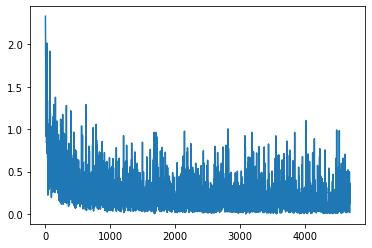

In [192]:
import matplotlib.pyplot as plt
plt.plot(loss_record)

In [157]:
dataset.ner_label_type

['',
 'b-misc',
 'b-per',
 'i-per',
 'o',
 'i-misc',
 'i-loc',
 'b-loc',
 'b-org',
 'i-org']

In [153]:
len(dataset)

14987

In [139]:
import gensim
import gensim.downloader

In [118]:
wrd2vec = gensim.downloader.load("glove-wiki-gigaword-300")

In [129]:
'briefing' in wrd2vec

True